### Prepare the data

In [1]:
#import the library
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import seaborn as sns
import logging
#import tensorflow as tf
import os
import anndata

import importlib
import warnings
warnings.filterwarnings("ignore")
import pickle as pkl
from matplotlib.colors import LinearSegmentedColormap

In [3]:
os.chdir('E:/AAA_Labwork/capenterlab_mtb')
# adata = sc.read_h5ad("SeuratProject.h5ad")

In [6]:
adata

AnnData object with n_obs × n_vars = 157462 × 4751
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Sample', 'Donor', 'Condition', 'percent.mt', 'percent.rb', 'percent.tcr', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CTgene', 'CTnt', 'CTaa', 'CTstrict', 'clonalProportion', 'clonalFrequency', 'cloneSize', 'cloneType_v1', 'cloneType_v2', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.2', 'seurat_clusters', 'SCT_snn_res.0.3'
    var: 'features'
    uns: 'seurat_clusters_colors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs'

In [8]:
adata.obs['cloneType_v2']

CL002_nonLTBI:Inf_AAACCTGAGGATGGAA-1          NA
CL002_nonLTBI:Inf_AAACCTGAGGTGCTAG-1          NA
CL002_nonLTBI:Inf_AAACCTGCACTAAGTC-1          NA
CL002_nonLTBI:Inf_AAACCTGCAGGTGGAT-1          NA
CL002_nonLTBI:Inf_AAACCTGCATGCCACG-1          NA
                                          ...   
P079_LTBI:Inf_TTTGTCAAGAGGTAGA-1              NA
P079_LTBI:Inf_TTTGTCAAGCGTGAAC-1              NA
P079_LTBI:Inf_TTTGTCACAGCATACT-1        Expanded
P079_LTBI:Inf_TTTGTCACAGGGCATA-1              NA
P079_LTBI:Inf_TTTGTCAGTATATGGA-1              NA
Name: cloneType_v2, Length: 157462, dtype: category
Categories (3, object): ['Expanded', 'NA', 'Nonexpanded']

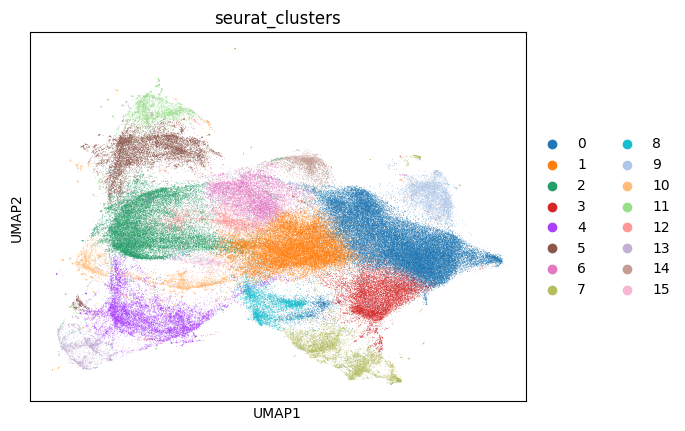

In [3]:
adata.obs['seurat_clusters'] = adata.obs['seurat_clusters'].astype(str)
sc.pl.umap(adata, color = 'seurat_clusters')

Fig 7B, I will define C3 and C0 as Viral specific yet low activation.
If the time allows I will also consider add in C9.

The goal is C14, C6, C12

In [10]:
sc.pp.log1p(adata)

In [13]:
adata_less_expanded = adata[adata.obs['seurat_clusters'].isin(['0','3'])]
adata_more_expanded = adata[adata.obs['seurat_clusters'].isin(['6','12','14'])]
adata_geneformer = adata_less_expanded.concatenate(adata_more_expanded,batch_key='expansion',batch_categories=['less','more'])

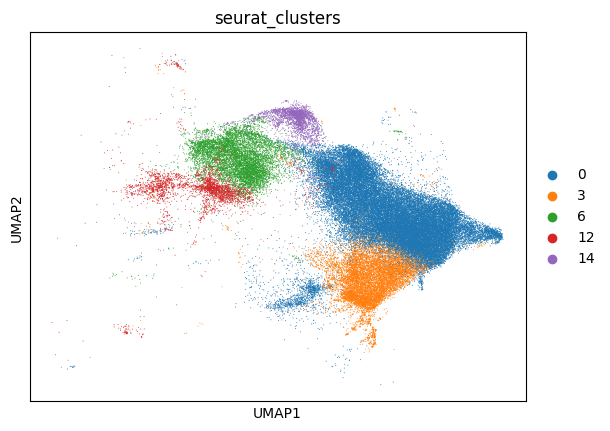

In [15]:
sc.pl.umap(adata_geneformer,color = 'seurat_clusters')

In [16]:
del adata_geneformer.var
del adata_geneformer.obsm

In [ ]:
adata_new = anndata.AnnData(X = adata_geneformer.raw.X)
adata_new.var_names = pd.read_csv('var_names.csv',index_col = 0).values.flatten().tolist()
adata_new.obs_names = adata_geneformer.obs_names
adata_new.obs = adata_geneformer.obs

In [ ]:
gene2tx = pd.read_csv('tx2gene_grch38_ens94.txt',sep = '\t',usecols = ['ensgene','symbol']).drop_duplicates(subset = 'symbol')
gene2tx.index = gene2tx['symbol']

In [ ]:
adata_new = adata_new[:,adata_new.var_names.isin(gene2tx.index)]

In [ ]:
ens_id = gene2tx['ensgene'].loc[adata_new.var_names]
adata_new.var['ensembl_id'] = ens_id

In [ ]:
adata_new.X = sp.sparse.csc_matrix(adata_new.X)

In [ ]:
adata_new.obs = adata_new.obs.astype(str)
adata_new.var = adata_new.var.astype(str)

In [ ]:
adata_new.obs['n_counts'] = adata_new.obs['nCount_RNA'].astype(float)

In [ ]:
adata_new.write("geneformer_mtb_new.h5ad")

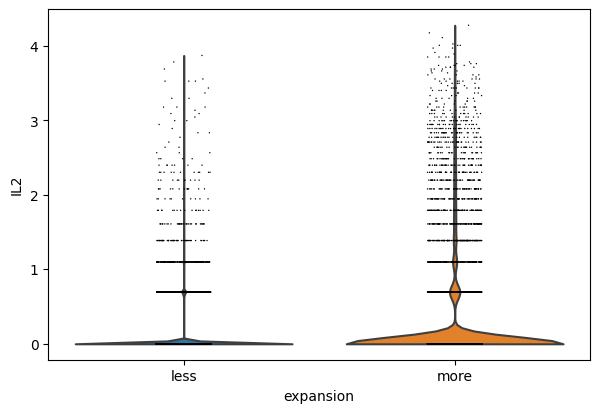

In [ ]:
sc.pl.violin(adata_new, groupby='expansion', keys = 'IL2')

In [4]:
adata_new = sc.read_h5ad("geneformer_mtb_new.h5ad")

In [6]:
adata_new_less = adata_new[adata_new.obs['expansion']=='less'] 

In [7]:
adata_new_more = adata_new[adata_new.obs['expansion']=='more'] 

In [8]:
adata_new_less.write('geneformer_mtb_new_less.h5ad')
adata_new_more.write('geneformer_mtb_new_more.h5ad')

### In the HPC

In [ ]:
#srun -p gpu --gres=gpu:1 --cpus-per-task=24 --mem=128G  --time=4200 --pty /bin/bash
import sys
import os
sys.path.append(os.getcwd())
from geneformer import InSilicoPerturber
from geneformer import InSilicoPerturberStats
from geneformer import EmbExtractor

In [ ]:
import logging

logging.basicConfig(
    filename='250327.log',
    level=logging.INFO,
    filemode='w', 
    format='%(asctime)s - %(levelname)s - %(message)s'  
)

In [ ]:
storage_dir = '/mnt/vstor/SOM_PATH_DKB50/members/rxr456/mtb'
output_prefix="mtb"
vanilla_model = "/home/rxr456/Geneformer/gf-12L-95M-i4096"

In [ ]:
from geneformer import TranscriptomeTokenizer
tk = TranscriptomeTokenizer({"expansion": "expansion"}, nproc=15)
tk.tokenize_data(f"{storage_dir}", 
                 f"{storage_dir}",
                 "tokenized", 
                 file_format="h5ad")

In [ ]:
from geneformer import Classifier
cc = Classifier(classifier="cell",
                cell_state_dict = {"state_key": "expansion", "states": "all"},
                max_ncells=None,
                freeze_layers = 6,
                num_crossval_splits = 1,
                split_sizes = {"train": 0.6, "valid": 0.2, "test": 0.2},
                forward_batch_size=150,
                nproc=47)


cc.prepare_data(input_data_file=f"{storage_dir}/tokenized.dataset",
                output_directory=f"{storage_dir}/",
                output_prefix=output_prefix)

all_metrics = cc.validate(model_directory="/home/rxr456/Geneformer/gf-12L-95M-i4096",
                          prepared_input_data_file=f"{storage_dir}/{output_prefix}_labeled_train.dataset",
                          id_class_dict_file=f"{storage_dir}/{output_prefix}_id_class_dict.pkl",
                          output_directory=f"{storage_dir}/",
                          output_prefix=output_prefix,
                          #n_hyperopt_trials=1,
                          predict_eval=True)


In [ ]:
model = f"{storage_dir}/250324_geneformer_cellClassifier_{output_prefix}/ksplit1/"

In [ ]:
# all_metrics = cc.validate(model_directory=model,
#                           prepared_input_data_file=f"{storage_dir}/{output_prefix}/{output_prefix}_labeled_train.dataset",
#                           id_class_dict_file=f"{storage_dir}/{output_prefix}/{output_prefix}_id_class_dict.pkl",
#                           output_directory=f"{storage_dir}/{output_prefix}/hyparam_test",
#                           output_prefix=output_prefix,
#                           n_hyperopt_trials=30,
#                           predict_eval=True)

In [ ]:
embex = EmbExtractor(model_type="CellClassifier",
                     num_classes=2, 
                     max_ncells=10000,
                     emb_layer=-1, 
                     emb_label=["expansion"],
                     labels_to_plot=["expansion"],
                     forward_batch_size=150,
                     nproc=80)


embs = embex.extract_embs(model,
                          f"{storage_dir}/tokenized.dataset",
                          f"{storage_dir}/",
                          output_prefix + "_embeddings_labeled")

embex.plot_embs(embs=embs,
                plot_style="heatmap",
                output_directory=f"{storage_dir}/",
                output_prefix="embeddings_heatmap")


# all_metrics_test = cc.evaluate_saved_model(
#         model_directory=model,
#         id_class_dict_file=f"{storage_dir}/{output_prefix}_id_class_dict.pkl",
#         test_data_file=f"{storage_dir}/{output_prefix}_labeled_test.dataset",
#         output_directory=f"{storage_dir}/",
#         output_prefix=output_prefix + output_prefix,
#     )

cc.plot_conf_mat(
        conf_mat_dict={"Geneformer": all_metrics["conf_matrix"]},
        output_directory=f"{storage_dir}/",
        output_prefix=output_prefix + output_prefix
)

In [ ]:
embex_test = EmbExtractor(model_type="CellClassifier",
                     num_classes=2,
                     emb_mode= "gene",
                     max_ncells=640,
                     emb_layer=-1,
                     emb_label=["expansion"],
                     labels_to_plot=["expansion"],
                     forward_batch_size=32,
                     nproc=16)

gene_embs_test = embex_test.extract_embs(
    model,
    f"{storage_dir}/tokenized.dataset",
    f"{storage_dir}/",
    "gene_embs_500_test"
)

that generated a n genes x 512 matrix, should be the exact mean of the gene's embedding in these 640 cells

change the model type "pretrained" to "cell classifier" does not change how gene embeddings are calculated

In [ ]:
isp = InSilicoPerturber(perturb_type="overexpress",
                        genes_to_perturb="all",
                        combos=0,
                        anchor_gene=None,
                        model_type="CellClassifier",
                        num_classes=2,
                        emb_mode="cls_and_gene",
                        max_ncells=1000,
                        emb_layer=-1,
                        forward_batch_size=128,
                        nproc=80)

isp.perturb_data(
    model,
    f"{storage_dir}/tokenized.dataset",
    f"{storage_dir}/",
    "gene_perturb_1000_128"
)

In [ ]:
ispstats = InSilicoPerturberStats(mode="aggregate_gene_shifts",
                                  genes_perturbed="all",
                                  combos=0,
                                  anchor_gene=None)

ispstats.get_stats(
    f"{storage_dir}/",
    None,
    f"{storage_dir}/",
    "gene_perturb_test"
)

In [ ]:
cell_states_to_model = {
    "state_key": "expansion", 
    "start_state": "less", 
    "goal_state": "more",
}

embex = EmbExtractor(model_type="CellClassifier",
                     num_classes=2, 
                     max_ncells=None,
                     emb_layer=-1, 
                     summary_stat="exact_mean",  # I don't want this stat
                     forward_batch_size=128,
                     nproc=80)

state_embs_dict = embex.get_state_embs(
    cell_states_to_model,
    model,
    f"{storage_dir}/tokenized.dataset",
    f"{storage_dir}/",
    "state_emb"
)

In [ ]:
isp = InSilicoPerturber(perturb_type="overexpress",
                        genes_to_perturb="all",
                        combos=0,
                        anchor_gene=None,
                        model_type="CellClassifier",
                        num_classes=2,
                        cell_states_to_model=cell_states_to_model,
                        state_embs_dict=state_embs_dict,
                        emb_mode="cls",
                        max_ncells=2000,
                        emb_layer=-1,
                        forward_batch_size=256,
                        nproc=80)

isp.perturb_data(
    model,
    f"{storage_dir}/tokenized.dataset",
    f"{storage_dir}/",
    "cell_state_shift_2000"
)

Suffer from limited resources and OOM, try only 50 selected gene

In [ ]:
import sys
import os
# pip install protobuf --target=/home/rxr456/miniconda3/envs/geneformer/lib/python3.10/site-packages
sys.path.append(os.getcwd())
from geneformer import InSilicoPerturber
from geneformer import InSilicoPerturberStats
storage_dir = '/mnt/vstor/SOM_PATH_DKB50/members/rxr456/mtb_new/'
vanilla_model = "/home/rxr456/Geneformer/gf-12L-95M-i4096"
model = f"{storage_dir}/250402_geneformer_cellClassifier_cell_state_shift_6000/ksplit1/"

In [ ]:
from geneformer import TranscriptomeTokenizer
tk = TranscriptomeTokenizer({"expansion": "expansion"}, nproc=20)
tk.tokenize_data(f"{storage_dir}/less", 
                 f"{storage_dir}/less",
                 "tokenized", 
                 file_format="h5ad")

In [ ]:
tk = TranscriptomeTokenizer({"expansion": "expansion"}, nproc=20)
tk.tokenize_data(f"{storage_dir}/more", 
                 f"{storage_dir}/more",
                 "tokenized", 
                 file_format="h5ad")

In [9]:
gene_names = [
    "LCK",
    "ZAP70",
    "LAT",
    "LCP2",      # (SLP76)
    "ITK",
    "CD28",
    "CTLA4",
    "ICOS",
    "PDCD1",
    "LAG3",
    "HAVCR2",    # (TIM3)
    "TNFRSF4",   # (OX40)
    "TNFRSF9",   # (4-1BB)
    "CD40LG",
    "IL2RA",     # (CD25)
    "IL7R",
    "IL2",
    "IFNG",
    "TNF",
    "IL10",
    "IL17A",
    "STAT1",
    "STAT3",
    "STAT4",
    "STAT5A",
    "STAT5B",
    "SOCS1",
    "NFKB1",
    "RELA",
    "DUSP2",
    "PTPN22",
    "TBX21",     # (T-bet)
    "GATA3",
    "RORC",      # (RORγt)
    "FOXP3",
    "BCL6",
    "IRF4",
    "BATF",
    "NFATC1",
    "NFATC2",
    "JUN",
    "FOS",
    "MTOR",
    "AKT1",
    "EOMES",
    "PRDM1",     # (Blimp-1)
    "ID2",
    "TOX",
    "CCL5",      # (RANTES)
    "CXCL10"
]

In [10]:
gene2tx = pd.read_csv('tx2gene_grch38_ens94.txt',sep = '\t',usecols = ['ensgene','symbol']).drop_duplicates(subset = 'symbol')
gene2tx.index = gene2tx['symbol']

In [13]:
ens_id = gene2tx['ensgene'].loc[gene_names]
ens_id.values.tolist()

['ENSG00000182866',
 'ENSG00000115085',
 'ENSG00000213658',
 'ENSG00000043462',
 'ENSG00000113263',
 'ENSG00000178562',
 'ENSG00000163599',
 'ENSG00000163600',
 'ENSG00000188389',
 'ENSG00000089692',
 'ENSG00000135077',
 'ENSG00000186827',
 'ENSG00000049249',
 'ENSG00000102245',
 'ENSG00000134460',
 'ENSG00000168685',
 'ENSG00000109471',
 'ENSG00000111537',
 'ENSG00000228849',
 'ENSG00000136634',
 'ENSG00000112115',
 'ENSG00000115415',
 'ENSG00000168610',
 'ENSG00000138378',
 'ENSG00000126561',
 'ENSG00000173757',
 'ENSG00000185338',
 'ENSG00000109320',
 'ENSG00000173039',
 'ENSG00000158050',
 'ENSG00000134242',
 'ENSG00000073861',
 'ENSG00000107485',
 'ENSG00000143365',
 'ENSG00000049768',
 'ENSG00000113916',
 'ENSG00000137265',
 'ENSG00000156127',
 'ENSG00000131196',
 'ENSG00000101096',
 'ENSG00000177606',
 'ENSG00000170345',
 'ENSG00000198793',
 'ENSG00000142208',
 'ENSG00000163508',
 'ENSG00000057657',
 'ENSG00000115738',
 'ENSG00000198846',
 'ENSG00000271503',
 'ENSG00000169245']

In [15]:
gene_id = ens_id.values.tolist()
gene_id

['ENSG00000182866',
 'ENSG00000115085',
 'ENSG00000213658',
 'ENSG00000043462',
 'ENSG00000113263',
 'ENSG00000178562',
 'ENSG00000163599',
 'ENSG00000163600',
 'ENSG00000188389',
 'ENSG00000089692',
 'ENSG00000135077',
 'ENSG00000186827',
 'ENSG00000049249',
 'ENSG00000102245',
 'ENSG00000134460',
 'ENSG00000168685',
 'ENSG00000109471',
 'ENSG00000111537',
 'ENSG00000228849',
 'ENSG00000136634',
 'ENSG00000112115',
 'ENSG00000115415',
 'ENSG00000168610',
 'ENSG00000138378',
 'ENSG00000126561',
 'ENSG00000173757',
 'ENSG00000185338',
 'ENSG00000109320',
 'ENSG00000173039',
 'ENSG00000158050',
 'ENSG00000134242',
 'ENSG00000073861',
 'ENSG00000107485',
 'ENSG00000143365',
 'ENSG00000049768',
 'ENSG00000113916',
 'ENSG00000137265',
 'ENSG00000156127',
 'ENSG00000131196',
 'ENSG00000101096',
 'ENSG00000177606',
 'ENSG00000170345',
 'ENSG00000198793',
 'ENSG00000142208',
 'ENSG00000163508',
 'ENSG00000057657',
 'ENSG00000115738',
 'ENSG00000198846',
 'ENSG00000271503',
 'ENSG00000169245']

In [ ]:
gene_ids = ['ENSG00000182866',
 'ENSG00000115085',
 'ENSG00000213658',
 'ENSG00000043462',
 'ENSG00000113263',
 'ENSG00000178562',
 'ENSG00000163599',
 'ENSG00000163600',
 'ENSG00000188389',
 'ENSG00000089692',
 'ENSG00000135077',
 'ENSG00000186827',
 'ENSG00000049249',
 'ENSG00000102245',
 'ENSG00000134460',
 'ENSG00000168685',
 'ENSG00000109471',
 'ENSG00000111537', #'ENSG00000228849'is not in geneformer
 'ENSG00000136634',
 'ENSG00000112115',
 'ENSG00000115415',
 'ENSG00000168610',
 'ENSG00000138378',
 'ENSG00000126561',
 'ENSG00000173757',
 'ENSG00000185338',
 'ENSG00000109320',
 'ENSG00000173039',
 'ENSG00000158050',
 'ENSG00000134242',
 'ENSG00000073861',
 'ENSG00000107485',
 'ENSG00000143365',
 'ENSG00000049768',
 'ENSG00000113916',
 'ENSG00000137265',
 'ENSG00000156127',
 'ENSG00000131196',
 'ENSG00000101096',
 'ENSG00000177606',
 'ENSG00000170345',
 'ENSG00000198793',
 'ENSG00000142208',
 'ENSG00000163508',
 'ENSG00000057657',
 'ENSG00000115738',
 'ENSG00000198846',
 'ENSG00000271503',
 'ENSG00000169245']

gene_ids = ['ENSG00000182866']

for gene_id in gene_ids:
    isp = InSilicoPerturber(perturb_type="overexpress",
                            genes_to_perturb=[gene_id],
                            combos=0,
                            anchor_gene=None,
                            model_type="CellClassifier",
                            num_classes=2,
                            emb_mode="cls_and_gene",
                            max_ncells=10000,
                            emb_layer=-1,
                            forward_batch_size=1,
                            nproc=80)
    os.makedirs(f"{storage_dir}/less/{gene_id}/")
    isp.perturb_data(
        model,
        f"{storage_dir}/less/tokenized.dataset",
        f"{storage_dir}/less/{gene_id}/",
        "gene_perturb_10000_1_selectedgene"
    )
    ispstats = InSilicoPerturberStats(mode="aggregate_gene_shifts",
                                    genes_perturbed=[gene_id],
                                    combos=0,
                                    anchor_gene=None)
    ispstats.get_stats(
        f"{storage_dir}/less/{gene_id}/",
        None,
        f"{storage_dir}/less/{gene_id}/",
        "gene_perturb_10000_1_selectedgene"
        )

In [ ]:
gene_ids = ['ENSG00000182866',
 'ENSG00000115085',
 'ENSG00000213658',
 'ENSG00000043462',
 'ENSG00000113263',
 'ENSG00000178562',
 'ENSG00000163599',
 'ENSG00000163600',
 'ENSG00000188389',
 'ENSG00000089692',
 'ENSG00000135077',
 'ENSG00000186827',
 'ENSG00000049249',
 'ENSG00000102245',
 'ENSG00000134460',
 'ENSG00000168685',
 'ENSG00000109471',
 'ENSG00000111537', #'ENSG00000228849'is not in geneformer
 'ENSG00000136634',
 'ENSG00000112115',
 'ENSG00000115415',
 'ENSG00000168610',
 'ENSG00000138378',
 'ENSG00000126561',
 'ENSG00000173757',
 'ENSG00000185338',
 'ENSG00000109320',
 'ENSG00000173039',
 'ENSG00000158050',
 'ENSG00000134242',
 'ENSG00000073861',
 'ENSG00000107485',
 'ENSG00000143365',
 'ENSG00000049768',
 'ENSG00000113916',
 'ENSG00000137265',
 'ENSG00000156127',
 'ENSG00000131196',
 'ENSG00000101096',
 'ENSG00000177606',
 'ENSG00000170345',
 'ENSG00000198793',
 'ENSG00000142208',
 'ENSG00000163508',
 'ENSG00000057657',
 'ENSG00000115738',
 'ENSG00000198846',
 'ENSG00000271503',
 'ENSG00000169245']
for less_or_more in ['less','more']:
    for gene_id in gene_ids:
        isp = InSilicoPerturber(perturb_type="overexpress",
                                genes_to_perturb=[gene_id],
                                combos=0,
                                anchor_gene=None,
                                model_type="CellClassifier",
                                num_classes=2,
                                emb_mode="cls_and_gene",
                                max_ncells=10000,
                                emb_layer=-1,
                                forward_batch_size=1,
                                nproc=80)
        try:
            os.makedirs(f"{storage_dir}/{less_or_more}/{gene_id}/")
        except:
            print('path already exist!')
        isp.perturb_data(
            model,
            f"{storage_dir}/{less_or_more}/tokenized.dataset",
            f"{storage_dir}/{less_or_more}/{gene_id}/",
            "gene_perturb_10000_1_selectedgene"
        )
        ispstats = InSilicoPerturberStats(mode="aggregate_gene_shifts",
                                        genes_perturbed=[gene_id],
                                        combos=0,
                                        anchor_gene=None)
        ispstats.get_stats(
            f"{storage_dir}/{less_or_more}/{gene_id}/",
            None,
            f"{storage_dir}/{less_or_more}/{gene_id}/",
            "gene_perturb_10000_1_selectedgene"
            )